<a href="https://colab.research.google.com/github/antiantono/bts-stat-anti/blob/main/assignments/SFDS_3rd_Assignment_AA_ldn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment III

You can work on this assignment on your own or in pairs. 

I would like you to be a bit creative with this last one, I will give you a suggested list, but feel free to add some extra analysis! Data science is never a rutine or a standard procedure ;)

- Pick a meaningful dataset for you
- **Briefly** summarize what it contains
- Test at least 3 hypothesis. Define them previously, writing down H0 and H1, your significance level and confidence. Would be nice if you use different tests. Extra points if the tests are interesting ;)
- Pick two numerical variables and adjust a linear model between them. Show the plot and describe what can be said about the model ($R^2$, coefficients, significance...). I don't want the variables to be perfectly correlated, I want the explanation to be right and clear. It is fine if the model is a disaster.
- Adjust a new model with at least 2 independent variables. One of them should be categorical and the other one numerical. Give a meaningful interpretation of the model. Does it increase its performance against the simple regression one? How?

Be visual please! Think about this assignment more like a business report rather than a university activity.

Some suggested sources for datasets:

- https://www.kaggle.com/datasets?fileType=csv&sizeEnd=50%2CMB
- https://piktochart.com/blog/100-data-sets/
- https://towardsdatascience.com/all-the-datasets-you-need-to-practice-data-science-skills-and-make-a-great-portfolio-857a348883b5
- https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/P4-Demographic-Data.csv

or...

#0 Notes to Instructor

### About the dataset
* **Source**: https://data.london.gov.uk/dataset/number-international-visitors-london
* **Content**: The quarterly data were taken from the International Passenger Survey (IPS). Data is for London only, showing total visits, nights and spend. Data is broken down by period, purpose, duration of stay, mode of travel and the visitors' country. 

#1 Prepare data

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme()

In [2]:
# Setup for multi-line printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

##1.1 Full dataset

In [3]:
# Read full dataset
raw = 'https://raw.githubusercontent.com/antiantono/bts-stat-anti/main/data/international-visitors-london-raw.csv'
df_full = pd.read_csv(raw)
df_full.head()

,year,quarter,market,dur_stay,mode,purpose,area,Visits (000s),Spend (m),Nights (000s),sample
0,2002,January-March,Belgium,1-3 nights,Air,Holiday,LONDON,3.572186,0.969138,6.954456,5
1,2002,January-March,Belgium,1-3 nights,Air,Business,LONDON,9.284226,2.399577,12.604959,19
2,2002,January-March,Belgium,1-3 nights,Air,VFR,LONDON,0.877182,0.089833,2.153128,3
3,2002,January-March,Belgium,1-3 nights,Air,Miscellaneous,LONDON,0.163874,0.010160,0.163874,1
4,2002,January-March,Belgium,1-3 nights,Sea,Business,LONDON,1.648670,0.016789,1.650300,1


### Consideration
We want to estimate spending by visitors to London, and want to target the big spenders. 

*Question : Tourists from which country spend the most amount of money on average?*

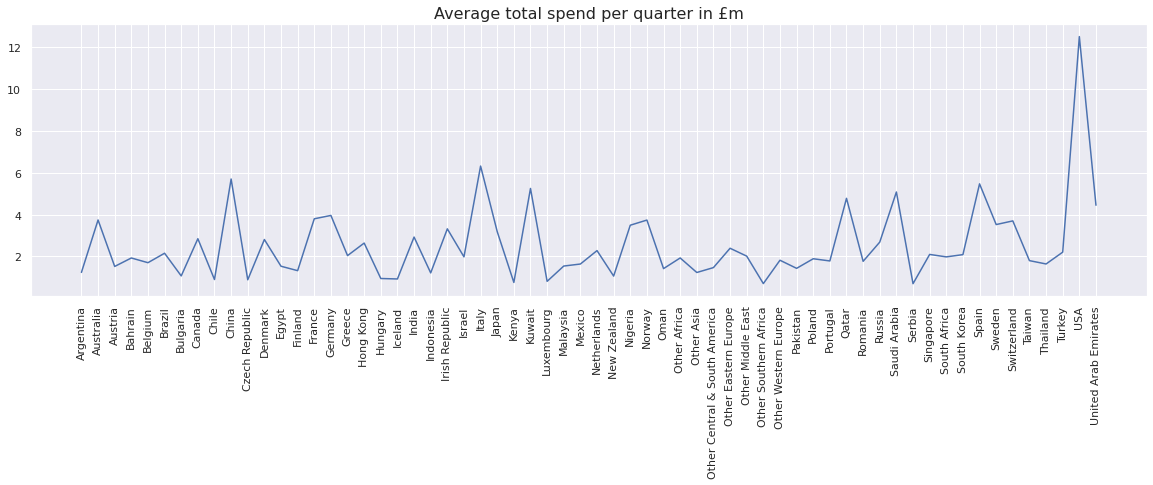

In [5]:
# Visualize spend by country
spend_by_country = df_full['Spend (m)'].groupby(df_full['market']).mean()

_= plt.subplots(1,1,figsize=(20,5))
_= plt.xticks(rotation=90)
_= plt.title('Average total spend per quarter in £m', fontsize=16)
_= plt.plot(spend_by_country)

plt.show()

##1.2 Data for analysis

###Selected data
Based on the country with the highest spending, we'll do our analysis focusing on the US market.

In [6]:
# Create a new dataset just for the US market

df = df_full.copy()
df = df[df['market'] == 'USA']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2498 entries, 354 to 61148
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           2498 non-null   object 
 1   quarter        2498 non-null   object 
 2   market         2498 non-null   object 
 3   dur_stay       2498 non-null   object 
 4   mode           2498 non-null   object 
 5   purpose        2498 non-null   object 
 6   area           2498 non-null   object 
 7   Visits (000s)  2498 non-null   float64
 8   Spend (m)      2498 non-null   float64
 9   Nights (000s)  2498 non-null   float64
 10  sample         2498 non-null   int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 234.2+ KB


In [7]:
df.describe()

,Visits (000s),Spend (m),Nights (000s),sample
count,2498.000000,2498.000000,2498.000000,2498.000000
mean,16.844954,12.519774,95.728161,30.028022
std,23.581476,20.249905,137.472614,45.063547
min,0.015758,0.000000,0.015758,1.000000
25%,1.592734,0.898261,9.565157,2.000000
50%,5.089804,4.330903,39.208743,7.000000
75%,24.499423,14.189040,134.509866,41.000000
max,182.477796,196.159302,2492.178513,299.000000


In [8]:
df.describe(exclude=np.number)

,year,quarter,market,dur_stay,mode,purpose,area
count,2498,2498,2498,2498,2498,2498,2498
unique,19,4,1,4,3,5,1
top,2004,July-September,USA,1-3 nights,Air,Holiday,LONDON
freq,162,674,2498,699,1370,748,2498


In [9]:
# Rename columns
df.columns = ['year', 'quarter', 'market', 'dur_stay', 'mode', 'purpose', 'area',
       'visits_000s', 'spend_gbp_m', 'nights_000s', 'sample']

In [10]:
# Check data range : note that 2020 data are predictions (denoted by P) 
df.year.values

array(['2002', '2002', '2002', ..., '2020P', '2020P', '2020P'],
      dtype=object)

In [11]:
# Only 25 data points labelled 2020P, and Jan-March only 
# We'll exclude these data points from modelling

len(df[df.year == '2020P'])
df[df.year == '2020P'].head(3)

25

,year,quarter,market,dur_stay,mode,purpose,area,visits_000s,spend_gbp_m,nights_000s,sample
61124,2020P,January-March,USA,1-3 nights,Air,Holiday,LONDON,68.135685,28.098724,152.020095,66
61125,2020P,January-March,USA,1-3 nights,Air,Business,LONDON,29.298831,29.721161,67.659643,51
61126,2020P,January-March,USA,1-3 nights,Air,VFR,LONDON,23.772412,9.077245,58.678327,31


In [12]:
# Drop 2020P > new dataset has 2498 - 25 = 2473 data points
df.drop(df[df.year == '2020P'].index, inplace=True)
len(df)

2473

In [13]:
# Check NA - we're good!
df.isna().sum()

year           0
quarter        0
market         0
dur_stay       0
mode           0
purpose        0
area           0
visits_000s    0
spend_gbp_m    0
nights_000s    0
sample         0
dtype: int64

#2 Data Exploration

##2.1 Visual Check

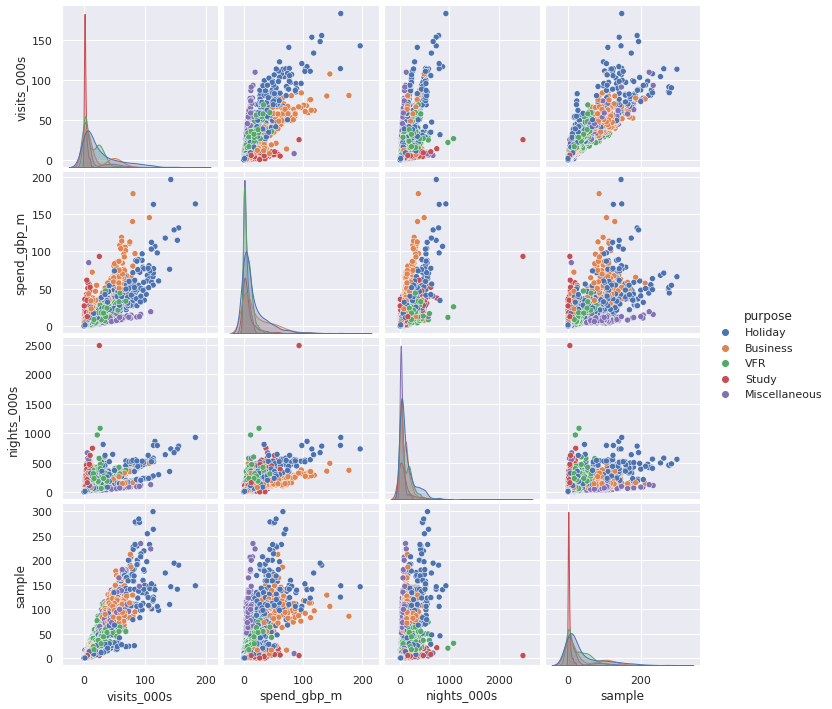

In [14]:
# Check if there could be a linear relationship between spend and other variables
_= sns.pairplot(df, hue='purpose')

### Findings from visual check
(1) Based on the plots above, it looks like both total visits and total nights have fairly linear relationships with visitors' spending in London.

(2) Moreover, data from different purposes of visit seem to have slightly different impact on spending (note the scatterplots between vists, nights vs. spending).

(3) There is an extreme outlier in 'nights_000s' - we should take this out.

In [15]:
# Remove the extreme outlier
df.loc[df.nights_000s > 2000] = np.NaN
df.dropna(inplace=True)
len(df)

2472

##2.2 Correlations
Based on the visual check, we have two candidates for regression variables : total visits (number of visitors) and total nights. Now we'd like to check the strength of correlation between these variables and total spending.

Corr = 0.7275040744924869


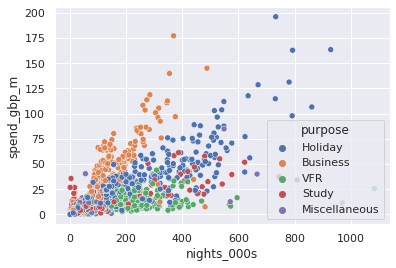

In [16]:
# Nights vs Spend 
print("Corr =", np.corrcoef(df.nights_000s.dropna(),df.spend_gbp_m.dropna())[0,1])
_= sns.scatterplot(x='nights_000s', y='spend_gbp_m', data=df, hue='purpose')

Corr = 0.8047208327932212


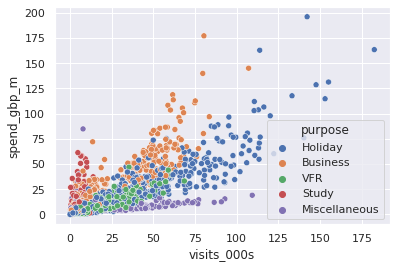

In [17]:
# Visits vs Spend 
print("Corr =", np.corrcoef(df.visits_000s.dropna(),df.spend_gbp_m.dropna())[0,1])
_= sns.scatterplot(x='visits_000s', y='spend_gbp_m', data=df, hue='purpose')

### Findings from correlation check
Total number of visitors has a slightly stronger correlation to spend -- we'll use this data for the regression model later. 

#3 Hypothesis Tests

##3.1 Sig check functions

In [21]:
# TWO-TAIL TEST
def sigtest_two_tail(p,confidence=0.95):
  if p < (1-confidence):
    print(f"Result is significant at {confidence} confidence level: we accept H1")
  else:
    print(f"Result is not significant at {confidence} confidence level: we accept H0")

# ONE-TAIL TEST
def sigtest_one_tail(p,confidence=0.95):
  if p/2 < (1-confidence):
    print(f"Result is significant at {confidence} confidence level: we accept H1")
  else:
    print(f"Result is not significant at {confidence} confidence level: we accept H0")

##3.2 t-test
From my own experience, I know London in the summer months are choc-full of tourists (you can spot them because they walk too slowly). Does the data show this?

$H0$ : The average number of visits is *the same* in warmer months (April-Sept) vs. colder months (Oct-Mar) 

$H1$ : The average number of visits is *higher* in warmer vs. colder months 

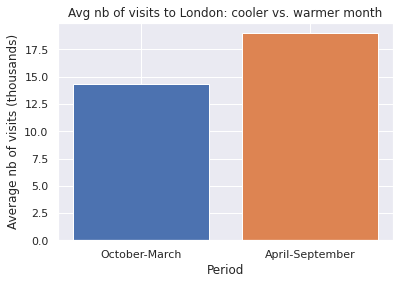

In [19]:
# Check the mean number of visits
# It's true warmer months have higher number of visits to London, but are they significant?

warmer = df[np.logical_or(df.quarter == 'April-June', df.quarter == 'July-September')]
cooler = df[np.logical_or(df.quarter == 'October-December', df.quarter == 'January-March')]

_= plt.bar('October-March', cooler['visits_000s'].mean())
_= plt.bar('April-September', warmer['visits_000s'].mean())
_= plt.xlabel('Period')
_= plt.ylabel('Average nb of visits (thousands)')
_= plt.title('Avg nb of visits to London: cooler vs. warmer month', fontsize = 12)

plt.show()

In [22]:
# Test the difference with a one-tail t-test 
# Result: yes, the difference is significant at 95% confidence level

from scipy.stats import ttest_ind

tstat, p = ttest_ind(warmer['visits_000s'], cooler['visits_000s'], equal_var= False)
print("t-test stat: ", tstat)
print("p-value:     ", p)
print("")
sigtest_one_tail(p)

t-test stat:  5.059227183293718
p-value:      4.529075177149824e-07

Result is significant at 0.95 confidence level: we accept H1


##3.4 ANOVA
Do visitors spend more depending on the purpose of visit?

$H0$ : The average spending is *similar* across different purposes of visit.

$H1$ : The average spending is *different* across different purposes of visit.

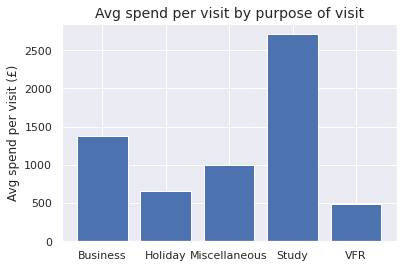

purpose
Business         1379.0
Holiday           664.0
Miscellaneous     999.0
Study            2710.0
VFR               490.0
Name: spend_per_visit, dtype: float64

In [55]:
# Check means of spending per visit
# Those who came to study spend more per visit than any other group
df['spend_per_visit'] = 1000 * (df['spend_gbp_m'] / df['visits_000s'])

# Visualize
xlabels = ['Business', 'Holiday', 'Miscellaneous', 'Study', 'VFR']

_= plt.bar(xlabels, df['spend_per_visit'].groupby(df['purpose']).mean())
_= plt.ylabel('Avg spend per visit (£)')
_= plt.title('Avg spend per visit by purpose of visit', fontsize=14)

plt.show()

# Means values
round(df['spend_per_visit'].groupby(df['purpose']).mean(),0)

In [36]:
for categories in xlabels:
  print(valuelabels[categories])

1379.0
664.0
999.0
2710.0
490.0


In [42]:
# Prepare the data for ANOVA test
df_bus = df.loc[df['purpose'] == 'Business', ['spend_per_visit']]
df_hol = df.loc[df['purpose'] == 'Holiday', ['spend_per_visit']]
df_mis = df.loc[df['purpose'] == 'Miscellaneous', ['spend_per_visit']]
df_stu = df.loc[df['purpose'] == 'Study', ['spend_per_visit']]
df_vfr = df.loc[df['purpose'] == 'VFR', ['spend_per_visit']]

In [43]:
# ANOVA test : as we suspected when we checked the means, the ANOVA test result came significant.
from scipy.stats import f_oneway
fstat, p = f_oneway(df_bus, df_hol, df_mis, df_stu, df_vfr)
print("ANOVA F-stat: ", fstat)
print("p-value:      ", p)
print("")

sigtest_two_tail(p)

ANOVA F-stat:  [83.08268267]
p-value:       [2.93688345e-66]

Result is significant at 0.95 confidence level: we accept H1


##3.3 Chi-square
Do people take different modes of transportation (air, sea, rail), given their purpose of visit (business, study etc)?

$H0$ : Purpose of visit *is not* associated with the choice of transportation mode.

$H1$ : Purpose of visit *is* associated with the choice of transportation mode. 

In [44]:
# Create contingency table
df_chi_obs = pd.crosstab(df['purpose'], df['mode']).astype(int)
df_chi_obs

mode,Air,Sea,Tunnel
purpose,,,
Business,288,41,179
Holiday,288,210,243
Miscellaneous,283,48,77
Study,205,14,55
VFR,288,67,186


In [46]:
# Chi square test
from scipy.stats import chi2_contingency

chi2, p, dof, df_chi_exp = chi2_contingency(df_chi_obs)
print("Observed values:\n", df_chi_obs)
print("")
print("Expected values:\n", df_chi_exp)
print("")
print("Chi-square stat:  ", chi2)
print("p-value:          ", p)
print("Degree of freedom:", dof)
print("")
sigtest_two_tail(p)

Observed values:
 mode           Air  Sea  Tunnel
purpose                        
Business       288   41     179
Holiday        288  210     243
Miscellaneous  283   48      77
Study          205   14      55
VFR            288   67     186

Expected values:
 [[277.8381877   78.09061489 152.07119741]
 [405.27184466 113.90776699 221.82038835]
 [223.14563107  62.7184466  122.13592233]
 [149.85760518  42.1197411   82.02265372]
 [295.88673139  83.16343042 161.94983819]]

Chi-square stat:   230.85550300515405
p-value:           1.951998139032514e-45
Degree of freedom: 8

Result is significant at 0.95 confidence level: we accept H1


We now know that purpose of visit is associated with purpose of visit. Let's explore on how the modes of transport differ by purpose of visit. Time to visualize! 

In [47]:
# First, get a total column across all modes of transport 
df_chi_obs['Total'] = df_chi_obs[['Air', 'Sea', 'Tunnel']].sum(axis=1)
df_chi_obs

mode,Air,Sea,Tunnel,Total
purpose,,,,
Business,288,41,179,508
Holiday,288,210,243,741
Miscellaneous,283,48,77,408
Study,205,14,55,274
VFR,288,67,186,541


In [49]:
# Calculate share of air / sea / tunnel travel as % of all visits by purpose 
air = df_chi_obs['Air'] / df_chi_obs['Total']
sea = df_chi_obs['Sea'] / df_chi_obs['Total']
tun = df_chi_obs['Tunnel'] / df_chi_obs['Total']

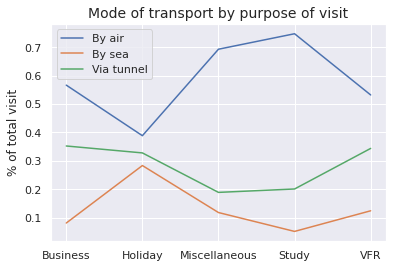

In [54]:
# Visualization shows us more insights about the association between purpose of visit and mode of transport 
## Air travel is highest among visitors who come to study -- not surprising as London universities are popular among international students
## While air travel always accounts for the highest share, sea travel is more popular among holidaymakers

_= plt.plot(air)
_= plt.plot(sea)
_= plt.plot(tun)

_= plt.ylabel('% of total visit')
_= plt.title('Mode of transport by purpose of visit', fontsize=14)
_= plt.legend(['By air', 'By sea', 'Via tunnel'])

plt.show()

#4 Linear regression

##4.1 Fitting univariate model
Based on the previous data check, it seems total number of visits is a good candidate to estimate total spend in London by US tourists. Not only does it have good correlation with total spend, but the data is also readily available from border control. 

In [56]:
# Variables for regression
x = df[['visits_000s']].dropna()
y = df[['spend_gbp_m']].dropna()

In [57]:
# Split into train vs test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

print("x_train, n=",len(x_train), "\nx_test, n=",len(x_test))

x_train, n= 2224 
x_test, n= 248


In [58]:
# Fit the model
from sklearn import linear_model 
  
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
# Check model performance
from sklearn.metrics import r2_score, mean_squared_error

print("MODEL PERFORMANCE - KEY METRICS")

# Internal prediction with training set
y_train_pred = regr.predict(x_train)
print("Training set: \tr2=", round(r2_score(y_train, y_train_pred),3), 
      "\tMSE=", round(mean_squared_error(y_train, y_train_pred),2))

# External prediction with test set
y_test_pred = regr.predict(x_test)
print("Test set: \tr2=", round(r2_score(y_test, y_test_pred),3), 
      "\tMSE=", round(mean_squared_error(y_test, y_test_pred),2))

MODEL PERFORMANCE - KEY METRICS
Training set: 	r2= 0.646 	MSE= 142.89
Test set: 	r2= 0.657 	MSE= 152.72


In [81]:
# Get parameters
b = regr.intercept_
m = regr.coef_

model1 = f"y = {round(b[0],2)} + {round(m[0][0],2)}*visits" 
print("Model 1 formula: ", model1)

# Set regression line
xline = [0,200]
yline = b + m*xline

Model 1 formula:  y = 0.81 + 0.69*visits


In [63]:
# Store errors from model 1
err1_train = (y_train - y_train_pred)
err1_test = (y_test - y_test_pred)

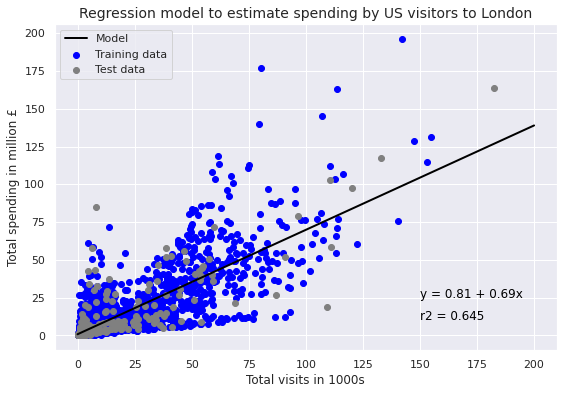

In [67]:
# Visualize
_= plt.subplots(1,1, figsize = (9,6))

_= plt.scatter(x_train, y_train, color='blue')
_= plt.scatter(x_test, y_test, color='grey')
_= plt.plot(xline, yline[0], color = 'black', linewidth = 2)

_= plt.xlabel('Total visits in 1000s')
_= plt.ylabel('Total spending in million £')
_= plt.annotate(model1, (150, 25), fontsize = 12, color='black')
_= plt.annotate('r2 = 0.645', (150, 10), fontsize = 12, color='black')
_= plt.legend(['Model', 'Training data', 'Test data'], loc='upper left')
_= plt.title('Regression model to estimate spending by US visitors to London', fontsize = 14)

plt.show()

### Summary : Model 1
Our first model isn't so bad, with r2 ~ 0.6 and good performance with the test set. But can it be improved? 

From the EDA we see indications that different purposes of visit may affect the regression slope. Let's try to add some dummy variables based on purpose of visit.

##4.2 Fitting multivariate model
We want to see if adding information about purpose of visit will improve the  univariate model to predict visitors' spend based on only the number of visits.

In [68]:
# Variables for regression
x2 = x
y2 = y

# Add dummy data to predictors
dummies = pd.get_dummies(df.purpose)
x2 = dummies.add(x2, fill_value=0)
x2.head(3)

,Business,Holiday,Miscellaneous,Study,VFR,visits_000s
354,0.0,1.0,0.0,0.0,0.0,42.570519
355,1.0,0.0,0.0,0.0,0.0,52.151314
356,0.0,0.0,0.0,0.0,1.0,23.125645


In [69]:
# Split the new dataset with dummies
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.1)

print("x2_train, n=",len(x2_train), "\nx2_test, n=",len(x2_test))

x2_train, n= 2224 
x2_test, n= 248


In [70]:
# Multivariate model fit with OLS from Statsmodels
import statsmodels.formula.api as smf

data = {"x2" : x2_train, "y2" : y2_train}
regr2 = smf.ols('y2 ~ x2', data=data).fit()

print(regr2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     1054.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        09:46:19   Log-Likelihood:                -8486.0
No. Observations:                2224   AIC:                         1.698e+04
Df Residuals:                    2218   BIC:                         1.702e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0391      0.241      4.312      0.0

In [83]:
# Model performance - R2 and MSE (internal prediction)
print("MODEL PERFORMANCE - KEY METRICS")

# Internal prediction with training set
train_data = {"x2" : x2_train}
y2_train_pred = regr2.predict(train_data)

print("Training set: \tr2=", round(r2_score(y2_train, y2_train_pred),3), 
      "\tMSE=", round(mean_squared_error(y2_train, y2_train_pred),2))

# External prediction with test set
test_data = {"x2" : x2_test}
y2_test_pred = regr2.predict(test_data)

print("Test set: \tr2=", round(r2_score(y2_test, y2_test_pred),3), 
      "\tMSE=", round(mean_squared_error(y2_test, y2_test_pred),2))

MODEL PERFORMANCE - KEY METRICS
Traing set: 	r2= 0.704 	MSE= 120.71
Test set: 	r2= 0.812 	MSE= 77.92


In [80]:
# Get params
p = [param for param in regr2.params]

model2 = f"y = {round(p[0],2)} + {round(p[1],2)}*business + {round(p[2],2)}*holiday \
+ {round(p[3],2)}*misc + {round(p[4],2)}*study + {round(p[5],2)}*VFR + + {round(p[6],2)}*visits"

print("Model2 formula: ", model2)

Model2 formula:  y = 1.04 + 8.34*business + -2.98*holiday + -4.54*misc + 4.68*study + -4.46*VFR + + 0.7*visits


In [94]:
# Store errors from model 2
err2_train = (y2_train['spend_gbp_m'] - y2_train_pred)
err2_test = (y2_test['spend_gbp_m'] - y2_test_pred)

### Summary : Model 2
By adding information about purpose of visit, we see a stronger model performance: higher r2 and lower MSE vs. Model 1. We also see good model performance with the test set.  

##4.3 Comparing Model 1 and 2

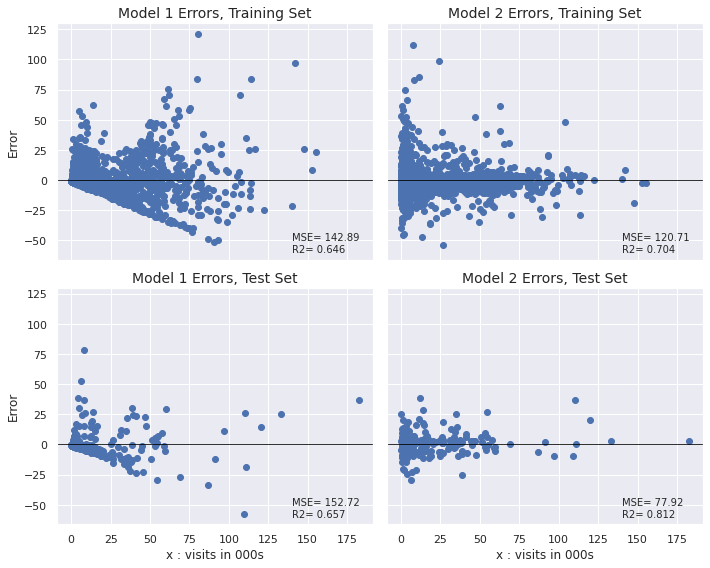

In [117]:
# Compare Model 1 vs Model 2
# Note : for this visualization, we will use x = visits for both models 

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,8))

# Model 1 Errors, Training Set
_= ax[0,0].scatter(x_train, err1_train)
_= ax[0,0].set_title('Model 1 Errors, Training Set', fontsize=14)
_= ax[0,0].axhline(0, color='black', linewidth=.8)
_= ax[0,0].annotate(f"MSE= {round(mean_squared_error(y_train, y_train_pred),2)}", (140, -50))
_= ax[0,0].annotate(f"R2= {round(r2_score(y_train, y_train_pred),3)}", (140, -60))

# Model 2 Errors, Training Set
_= ax[0,1].scatter(x_train, err2_train)
_= ax[0,1].set_title('Model 2 Errors, Training Set', fontsize=14)
_= ax[0,1].axhline(0, color='black', linewidth=.8)
_= ax[0,1].annotate(f"MSE= {round(mean_squared_error(y2_train, y2_train_pred),2)}", (140, -50))
_= ax[0,1].annotate(f"R2= {round(r2_score(y2_train, y2_train_pred),3)}", (140, -60))

# Model 1 Errors, Test Set
_= ax[1,0].scatter(x_test, err1_test)
_= ax[1,0].set_title('Model 1 Errors, Test Set', fontsize=14)
_= ax[1,0].axhline(0, color='black', linewidth=.8)
_= ax[1,0].annotate(f"MSE= {round(mean_squared_error(y_test, y_test_pred),2)}", (140, -50))
_= ax[1,0].annotate(f"R2= {round(r2_score(y_test, y_test_pred),3)}", (140, -60))

# Model 1 Errors, Training Set
_= ax[1,1].scatter(x_test, err2_test)
_= ax[1,1].set_title('Model 2 Errors, Test Set', fontsize=14)
_= ax[1,1].axhline(0, color='black', linewidth=.8)
_= ax[1,1].annotate(f"MSE= {round(mean_squared_error(y2_test, y2_test_pred),2)}", (140, -50))
_= ax[1,1].annotate(f"R2= {round(r2_score(y2_test, y2_test_pred),3)}", (140, -60))

# Axis labels
_= ax[0,0].set_ylabel('Error')
_= ax[1,0].set_ylabel('Error')
_= ax[1,0].set_xlabel('x : visits in 000s')
_= ax[1,1].set_xlabel('x : visits in 000s')

plt.tight_layout()
plt.show()

### Conclusion : Which Model?
By adding more information (purpose of visit), we improved the regression model: we see lower error (MSE) and higher correlation (R2) between the predicted spend vs. actual spend. The second model also performed well when given a new dataset. 

Therefore, I recommend using the second model : we predict spending by US visitors in London using number of visits and purpose of visits.